# 11-6. 프로젝트 : 폐렴 진단기 성능개선

---

모델이 X-ray 사진을 보고 정상인지 폐렴인지 분류해줍니다.  

정답이 주어진 지도 학습이지만, 이미지가 주어져 있기에 구분하는 방법을 간단하게 소개하겠습니다.  
정상적인 폐인 경우에 폐에 공기가 들어있기 때문에 X-ray의 폐부분은 어둡게 나타납니다.  
반면 폐렴 환자의 경우 폐 부위에 피와 고름 등이 차 있으면 X-ray 투과율이 떨어지므로 뿌연 음영이 관찰됩니다.

흉부 X-ray 사진은 아래에서 다운로드 받을 수 있습니다.  
[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

## Step 1. 실험환경 Set-up

In [26]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [28]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('테스트 데이터 갯수: {}'.format(len(test_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 5216
테스트 데이터 갯수: 624
검증 데이터 갯수: 16


- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.  
- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.  
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.  

In [29]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 4185
검증 데이터 갯수: 1047


In [30]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0614-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


In [31]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

- tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

In [32]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [33]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없습니다.
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [34]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [35]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [36]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [38]:
# 테스트 데이터도 동일한 작업을 해줍니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('테스트 데이터 갯수: {}'.format(TEST_IMAGE_COUNT))

테스트 데이터 갯수: 624


In [39]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.

- prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
- 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
- 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## Step 3. 데이터 시각화

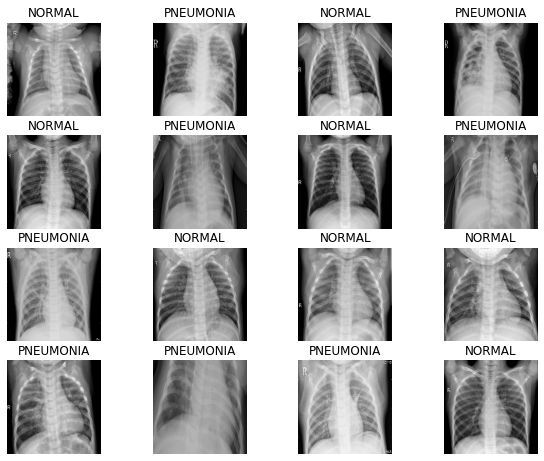

In [40]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [41]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [42]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [43]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [44]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


- 이 예의 앞부분에서 정상보다 폐렴으로 분류된 이미지가 더 많아 데이터가 불균형한 것을 보았습니다.
- 클래스 0(정상)의 가중치는 클래스 1(폐렴)의 가중치보다 훨씬 높습니다 .
- 정규 이미지가 적기 때문이며, CNN은 훈련 데이터가 균형을 이룰 때 가장 잘 작동하므로, 각 정상 이미지는 데이터 균형을 위해 더 많은 가중치를 부여합니다.

## Step 6. 모델 훈련

In [45]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [50]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)     

In [46]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 138ms/step - loss: 0.5608 - accuracy: 0.7255 - precision: 0.9077 - recall: 0.6989 - val_loss: 0.6879 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2397 - accuracy: 0.9030 - precision: 0.9721 - recall: 0.8948 - val_loss: 1.3152 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1835 - accuracy: 0.9289 - precision: 0.9808 - recall: 0.9225 - val_loss: 0.1221 - val_accuracy: 0.9577 - val_precision: 0.9800 - val_recall: 0.9620
Epoch 4/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1932 - accuracy: 0.9356 - precision: 0.9810 - recall: 0.9326 - val_loss: 0.1136 - val_accuracy: 0.9558 - val_precision: 0.9509 - val_recall: 0.9908
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1594 - accura

## Step 7. 결과 확인과 시각화

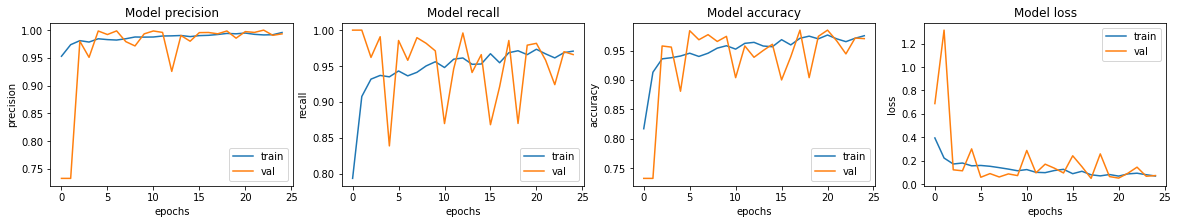

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.6942 - accuracy: 0.8510 - precision: 0.8153 - recall: 0.9846
Loss: 0.6942371726036072,
Accuracy: 0.8509615659713745,
Precision: 0.8152866363525391,
Recall: 0.9846153855323792


---

## 루브릭 관련 고려한 점

**1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**

- 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

**2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**

- regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

**3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.**

- Accuracy 기준 85%에 도달하였다.

## 회고


1️⃣ 잘한 점:  

- 노드 제작에 원본이 된 캐글과 케라스코드를 사전 학습했기 때문에 코드에 대한 이해도가 높았다.
- 한번 공부하면서 몰랐던 부분에 대해 체크하고 복습하는 개념으로 다시 공부하였다.


2️⃣ 어려웠던 점:  

- 에폭을 적게 돌려서인지 Accuracy 85%가 안나오고 에폭이나 배치를 늘리니 리콜값은 1이 나오지만 정확도와 재현률이 확연히 낮아 졌다.
- Data augmentation도 사용하고 모델레이어랑 콜백도 바꿔보고 드롭아웃이나 BatchNormalization도 건들여 봤지만 확연하게 85%로 오르지 않고 70~83% 언저리에서 미미하게 변동 되었다.
- 그런데 막상 다시 돌려보자는 마음으로 기본세팅되어 있는 값으로 다시 돌리니 Accuracy 85%가 넘게 나왔다.
- 랜덤셔플이 잘작동된건지 뭔지 모르겠지만 노력으로 얻은 결과가 아니라 요행같아서 허탈하기도 하다.
- 주어진 기준에 맞추는 것도 중요한데 보다 더 나은 결과를 내고 싶다.


3️⃣ 느낀 점:  

- 의료분별에 관한 문제이기에 Recall값이 중요하고, 그에 따른 Precision값을 효과적으로 올리는 방법을 실현하고 싶다.
- 아마 시도하다가 리콜은 1이 나왔는데 Accuracy와 Precision가 62.5%에서 멈췄을때를 생각해보면 모델이 모든 데이터를 다 정답이라고 해도 그렇게 나올 것 같다.
- 분류성능평가지표에 대해 고려할 수 있는 좋은 EXPLORATION이였다.


- 캐글 설명을 읽어보면 X-ray 스캔은 특정 방향으로만 촬영되고 뒤집기 및 회전과 같은 변형은 실제 X-ray 이미지에 존재하지 않기 때문에 data augmentation는 모델에 포함하지 않는다고 했다.
- 학습을 위해 이미지를 좌우반전하여 data augmentation도 시도해보긴 했으나, 의료데이터이기에 해당 기법이 긍정적인 효과를 주기만 하지 않는 다는 점을 배웠다.
- 모델의 정확도를 높이기 위해 데이터가 많이 필요하다고 생각했는데, 데이터가 부족한 상황에서 극복할 방법들을 배울 수 있어서 재밌었다.


- 정리를 하다가 다시보니 레이어를 추가한 값에서 가장 좋은 Accuracy 값을 확인했다.
- 개선을 해보겠다고 다시 돌리는 과정에서 저장한 파일을 찾을 수 없었다.
- 학습이라는 관점에서 시도를 한건 좋았지만 이를 정리하고 저장하는 게 중요하다고 느끼고 반성했다.

4️⃣ 시도한 방법들: 

- 정말 여러번 시도했으나 위 제출한 코드만 보면 노력의 결과가 안보이는 것 같아 남긴다.

1. 드롭아웃 유무
-  드롭아웃 있는 모델
      - Loss: 1.1453840732574463,   
        Accuracy: 0.8044871687889099,   
        Precision: 0.76171875,   
        Recall: 1.0   
        
        
- 드롭아웃 제거
    - Loss: 0.8105854392051697,   
        Accuracy: 0.7323718070983887,   
        Precision: 0.703839123249054,   
        Recall: 0.9871794581413269  

- BatchNormalization가 있는 경우 드롭아웃을 사용안해도 된다고 배웠으나 이번 경우에는 드롭아웃이 있는 경우가 조금 더 좋은 성능을 보였다.

2. data augmentation(이미지 좌우반전) 유무
- data augmentation 있는 결과값  
    - Loss: 0.6408160924911499,  
        Accuracy: 0.8205128312110901,  
        Precision: 0.7883817553520203,  
        Recall: 0.9743589758872986  
        
        
- data augmentation 제거  
    - Loss: 0.4325295388698578,     
        Accuracy: 0.8910256624221802,  
        Precision: 0.8761682510375977,  
        Recall: 0.9615384340286255  

- 같은 조건에서 data augmentation가 들어가지 않은 경우가 더 좋은 결과 값이 나왔다.